## Casualties

Analysis on the data on casualties

## Data Preparation

In [1]:
# import libraries

import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# load data
collision_attendant = pd.read_csv('data/jan-dec-2022-gla-data-extract-attendant.csv')
collision_casualties = pd.read_csv('data/jan-dec-2022-gla-data-extract-casualties.csv')
collision_vehicle = pd.read_csv('data/jan-dec-2022-gla-data-extract-vehicle.csv')

In [3]:
# create GeoDataFrames
attendant_gdf = gpd.GeoDataFrame(
    collision_attendant,
    geometry = gpd.points_from_xy(collision_attendant.Easting, collision_attendant.Northing, crs = 'EPSG:27700')
)

casualties_gdf = gpd.GeoDataFrame(
    collision_casualties,
    geometry = gpd.points_from_xy(collision_casualties.Easting, collision_casualties.Northing, crs = 'EPSG:27700')
)

vehicle_gdf = gpd.GeoDataFrame(
    collision_vehicle,
    geometry = gpd.points_from_xy(collision_vehicle.Easting, collision_vehicle.Northing, crs = 'EPSG:27700')
)

In [4]:
# save as gpkg
# attendant_gdf.to_file('data/2022_attendant.gpkg', driver = 'GPKG')
# casualties_gdf.to_file('data/2022_casualties.gpkg', driver = 'GPKG')
# vehicle_gdf.to_file('data/2022_vehicle.gpkg', driver = 'GPKG')

## Cycle Casualties

<Axes: >

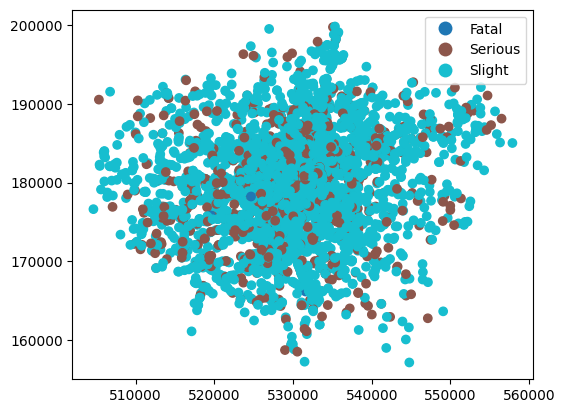

In [5]:
cycle_casualties = casualties_gdf[casualties_gdf['Casualty Mode of Travel'] == 'Pedal Cycle']

cycle_casualties.plot(
    column = cycle_casualties['_Casualty Severity'],
    legend = True
)

In [6]:
# get cycle casualties with fatal or serious results
cycle_severe = cycle_casualties[cycle_casualties['_Casualty Severity'] != 'Slight'].copy()

In [7]:
# merge with network data
columns = ['_Collision Id', 'Collision Location', '_Collision Severity', 'First Road Class', 'First Road Number', 'Second Road Class', 'Second Road Number', 'Pedestrian Crossing Facilities']
cycle_severe = cycle_severe.merge(attendant_gdf[columns], left_on = '_Collision Id', right_on = '_Collision Id')

In [8]:
# add column for road
cycle_severe['First Road'] = cycle_severe['First Road Class'] + cycle_severe['First Road Number'].astype(str)
cycle_severe['Second Road'] = cycle_severe['Second Road Class'] + cycle_severe['Second Road Number'].astype(str)

In [20]:
# count number of incidents
incidents_per_road = pd.DataFrame(
    pd.concat([cycle_severe['First Road'], cycle_severe['Second Road']]).value_counts()[3:]
).rename(columns = {'count': 'all_incidents'}).merge(
    pd.DataFrame(cycle_severe['First Road'].value_counts()).rename(columns = {'count': 'first_road'}),
    how = 'left',
    left_index = True,
    right_index = True
).merge(
    pd.DataFrame(cycle_severe['Second Road'].value_counts()).rename(columns = {'count': 'second_road'}),
    how = 'left',
    left_index = True,
    right_index = True    
).fillna(0)

In [23]:
incidents_per_road

,all_incidents,first_road,second_road
A3,40,31.0,9.0
A10,26,24.0,2.0
A205,23,18.0,5.0
A23,22,18.0,4.0
A11,21,19.0,2.0
...,...,...,...
B104,1,1.0,0.0
B319,1,1.0,0.0
A1011,1,1.0,0.0
A4088,1,1.0,0.0


### Merge with Road data

In [24]:
# load road data
tq_roads = gpd.read_file('data/os_open_roads/TQ_RoadLink.shp')

In [39]:
# load london boroughs
boroughs = gpd.read_file('data/London_Boroughs.gpkg')
boroughs_union = boroughs.unary_union

In [40]:
# london_roads = tq_roads[tq_roads.intersects(boroughs_union)]

In [43]:
london_roads.shape

(210753, 20)

In [42]:
# london_roads.to_file('data/london_roads.gpkg', driver = 'GPKG')

In [ ]:
london_roads = gpd.read_file('data/london_roads.gpkg')

In [51]:
# get road length within London
incidents_per_road = incidents_per_road.merge(london_roads_merged.groupby('roadNumber').agg({'length': 'sum'}), left_index = True, right_index = True, how = 'left')

In [53]:
incidents_per_road['incidents_per_metre'] = incidents_per_road['all_incidents'] / incidents_per_road['length']

In [58]:
incidents_per_road.sort_values(by = 'length')

,all_incidents,first_road,second_road,length,incidents_per_metre
B401,2,1.0,1.0,299.0,0.006689
B512,1,0.0,1.0,399.0,0.002506
B318,1,1.0,0.0,427.0,0.002342
B324,2,1.0,1.0,445.0,0.004494
B101,1,1.0,0.0,591.0,0.001692
...,...,...,...,...,...
B233,1,0.0,1.0,NaN,NaN
B457,1,0.0,1.0,NaN,NaN
A115,1,0.0,1.0,NaN,NaN
A1007,1,0.0,1.0,NaN,NaN


In [59]:
london_roads_merged = london_roads.merge(incidents_per_road, left_on = 'roadNumber', right_index = True, how = 'inner')

london_roads_merged

,fictitious,identifier,class,roadNumber,name1,name1_lang,name2,name2_lang,formOfWay,length_x,...,structure,nameTOID,numberTOID,function,geometry,all_incidents,first_road,second_road,length_y,incidents_per_metre
17,false,86DF6DFC-8FBB-497A-B8F6-CE729178CE3E,A Road,A105,Carterhatch Lane,None,None,None,Single Carriageway,62,...,None,osgb4000000030489899,osgb4000000030576133,A Road,"LINESTRING Z (534773.040 197478.680 0.000, 534...",15,15.0,0.0,18132.0,0.000827
24,false,900D3F9F-036D-475E-9E14-56388FDFF827,A Road,A105,Carterhatch Lane,None,None,None,Single Carriageway,87,...,None,osgb4000000030489899,osgb4000000030576133,A Road,"LINESTRING Z (534773.040 197478.680 0.000, 534...",15,15.0,0.0,18132.0,0.000827
35,false,F973D40B-4AB8-4764-B30F-CEDEAACA0EF6,A Road,A105,Carterhatch Lane,None,None,None,Single Carriageway,90,...,None,osgb4000000030489899,osgb4000000030576133,A Road,"LINESTRING Z (534950.000 197486.000 0.000, 534...",15,15.0,0.0,18132.0,0.000827
36,false,68A71AF1-8D34-42E2-8A64-08CF80246871,A Road,A105,Carterhatch Lane,None,None,None,Collapsed Dual Carriageway,127,...,None,osgb4000000030489899,osgb4000000030576133,A Road,"LINESTRING Z (534950.000 197486.000 0.000, 535...",15,15.0,0.0,18132.0,0.000827
230,false,64DF571C-B135-4C04-87D6-92379A7942B4,A Road,A105,Carterhatch Lane,None,None,None,Single Carriageway,155,...,None,osgb4000000030489899,osgb4000000030576133,A Road,"LINESTRING Z (534275.000 197480.000 0.000, 534...",15,15.0,0.0,18132.0,0.000827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292778,false,78935769-2F90-4F7A-BF2D-2CA012712F9D,A Road,A243,Leatherhead Road,None,None,None,Single Carriageway,47,...,None,osgb4000000030480801,osgb4000000030575904,A Road,"LINESTRING Z (517142.720 161288.510 0.000, 517...",1,1.0,0.0,8814.0,0.000113
292783,false,B4F4C564-F9C2-4327-B21E-710D4F29E4FF,A Road,A243,Leatherhead Road,None,None,None,Single Carriageway,82,...,None,osgb4000000030480801,osgb4000000030575904,A Road,"LINESTRING Z (517155.600 161333.570 0.000, 517...",1,1.0,0.0,8814.0,0.000113
292787,false,07EE9028-A2D5-408C-87C4-801EB48F9A77,A Road,A243,Leatherhead Road,None,None,None,Single Carriageway,105,...,None,osgb4000000030480801,osgb4000000030575904,A Road,"LINESTRING Z (517179.900 161411.650 0.000, 517...",1,1.0,0.0,8814.0,0.000113
292789,false,28173E2B-1A35-46AF-A3A0-D9BD27860AB0,A Road,A243,Leatherhead Road,None,None,None,Single Carriageway,95,...,None,osgb4000000030480801,osgb4000000030575904,A Road,"LINESTRING Z (517247.800 161598.970 0.000, 517...",1,1.0,0.0,8814.0,0.000113


<Axes: >

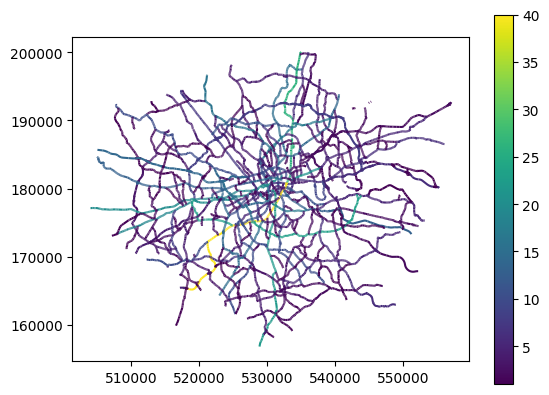

In [46]:
london_roads_merged.plot(
    column = 'all_incidents',
    legend = True
)

<Axes: >

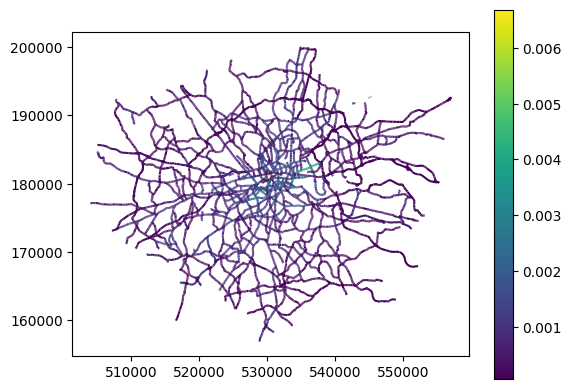

In [60]:
london_roads_merged.plot(
    column = 'incidents_per_metre',
    legend = True
)

In [61]:
# save as gpkg
london_roads_merged.to_file('data/london_roads_accidents.gpkg', driver = 'GPKG')

## Fatal Incidents

<Axes: >

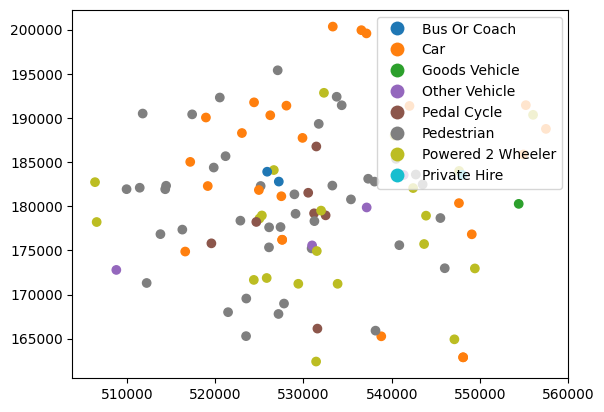

In [12]:
# plot fatal incidents
casualties_gdf[casualties_gdf['_Casualty Severity'] == 'Fatal'].plot(
    column = 'Casualty Mode of Travel',
    legend = True
)

In [13]:
attendant_gdf.columns

Index(['_Collision Id', 'Borough Name', 'Borough Number', 'Easting',
       'Northing', 'Collision Location', '_Collision Severity',
       '_Casualty Count', '_Vehicle Count', '_Collision Date', 'Day Name',
       'Time', 'Highway Authority', 'First Road Class', 'First Road Number',
       'Road Type', 'Speed Limit', 'Junction Detail', 'Junction Control',
       'Second Road Class', 'Second Road Number',
       'Pedestrian Crossing Facilities', 'Light Conditions', 'Weather Details',
       'Road Surface Condition', 'Special Conditions at Site',
       'Carriageway Hazards', 'Place Collision Reported', 'geometry'],
      dtype='object')

In [14]:
attendant_gdf['Second Road Class'].unique()

array(['Unclassified', 'A', 'Unknown', 'C', 'B', 'M'], dtype=object)

<Axes: >

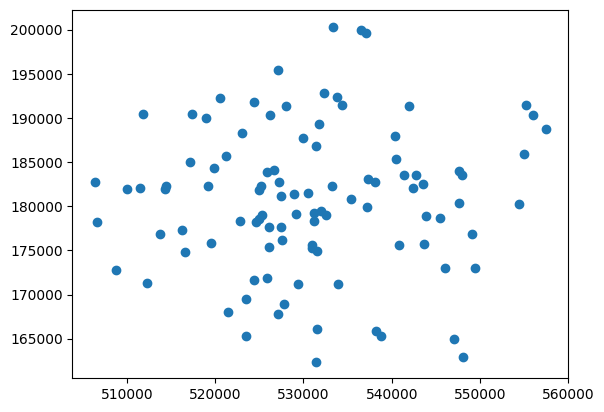

In [15]:
attendant_gdf[attendant_gdf['_Collision Severity'] == 'Fatal'].plot()

In [16]:
casualties_gdf['_Collision Id'].value_counts()

_Collision Id
1220356595     16
1220377133     16
1220392491     14
1220387761     14
1220395209     11
               ..
1220376536      1
1220376535      1
1220376530      1
1220376529      1
48221292435     1
Name: count, Length: 23465, dtype: int64

In [17]:
fatal_gdf = attendant_gdf[attendant_gdf['_Collision Severity'] == 'Fatal'].copy()

In [18]:
# count routes
(fatal_gdf['First Road Class'] + fatal_gdf['First Road Number'].astype(str)).value_counts()

Unclassified0    14
C0               13
A13               4
A4                4
A41               3
A3220             2
A236              2
A404              2
A4127             2
A406              2
M25               2
A12               2
A40               2
A217              2
A21               1
A2213             1
A3203             1
A316              1
A302              1
M11               1
A2043             1
A4201             1
A216              1
A503              1
A1055             1
A201              1
A410              1
A3004             1
A3204             1
A206              1
A127              1
A23               1
B223              1
A223              1
A111              1
A103              1
B193              1
A124              1
B509              1
A1008             1
A3202             1
B317              1
A3212             1
B550              1
A224              1
A212              1
A2016             1
A3044             1
B142              1
A308              1


In [19]:
# count routes
(fatal_gdf['Second Road Class'] + fatal_gdf['Second Road Number'].astype(str)).value_counts()

Unknown0         41
Unclassified0    34
C0                3
A23               2
A3220             2
A5109             1
A302              1
A127              1
A1201             1
A5205             1
A4201             1
A236              1
A40               1
A1203             1
B454              1
A114              1
B509              1
A110              1
B316              1
A2199             1
A406              1
A300              1
A3205             1
Name: count, dtype: int64